<a href="https://colab.research.google.com/github/DaniAngel79/log_anomaly_detector_distilbert_v2/blob/main/Log_Anomaly_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Instalamos las librerías necesarias:
# datasets: Para cargar el dataset HDFS
# transformers: Para el modelo DistilBERT y el Tokenizador
# accelerate: Para optimizar el entrenamiento en la GPU
!pip install datasets transformers accelerate --upgrade -q
!pip install wget -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import numpy as np

# --- CONFIGURACIÓN FINAL PARA EL DATASET SUBIDO ---
FILE_NAME = "1000_6.csv"
LABEL_COLUMN_INDEX = -1 # La etiqueta de texto está en la última columna

print(f"Cargando el dataset procesado: {FILE_NAME}...")

try:
    # 1. Cargar el DataFrame sin encabezados
    # Utilizamos 'header=None' porque el archivo CSV no tiene la primera fila con nombres de columna
    df = pd.read_csv(FILE_NAME, header=None)

    # 2. Asignar la última columna como la etiqueta de texto (ej: 'Adware', 'Clean')
    df['label_text'] = df.iloc[:, LABEL_COLUMN_INDEX]

    # 3. CONVERSIÓN DE DATOS Y ETIQUETAS

    # a) Crear la columna 'text': Concatenamos todas las características numéricas en una sola cadena
    # Esta es la entrada que el modelo de lenguaje (BERT) analizará.
    # Las columnas a concatenar son todas excepto las dos últimas (el índice de etiqueta numérica original y 'label_text')
    FEATURE_COLUMNS = df.columns[:-2]
    df['text'] = df[FEATURE_COLUMNS].astype(str).agg(','.join, axis=1)

    # b) Mapeo a Binario (0: Normal, 1: Anómalo)

    # Identificamos la clase más frecuente. En un dataset 'PlusClean', esta suele ser 'Clean'.
    most_frequent_label = df['label_text'].mode()[0]

    # Mapeo: Si la etiqueta es la más frecuente (asumimos que es la clase 'Clean'), es 0 (Normal).
    # Si es cualquier otra (Malware/Anomalía), es 1.
    df['label'] = np.where(df['label_text'] == most_frequent_label, 0, 1)

    # 4. Dividir el dataset en entrenamiento y prueba (90% / 10%)
    train_df, test_df = train_test_split(
        df[['text', 'label']], test_size=0.1, random_state=42, stratify=df['label']
    )

    # 5. Convertir a Dataset de Hugging Face
    train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
    test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

    # Almacenar en la variable global para las siguientes celdas
    global tokenized_datasets
    tokenized_datasets = {'train': train_dataset, 'test': test_dataset}

    print("\n¡Carga y Preparación Exitosa!")
    print(f"Total de entradas cargadas: {len(df)} filas.")
    print(f"Dataset de Entrenamiento (90%): {len(train_dataset)} filas.")
    print(f"Dataset de Prueba (10%): {len(test_dataset)} filas.")

    # Muestra de datos para confirmar
    print("\nMuestra de datos del set de entrenamiento (primeras 5 filas):")
    print(train_dataset[:5])

    # 6. Vemos la distribución de clases
    print("\nDistribución de Etiquetas (0: Normal, 1: Anómalo):")
    print(f"Clase 0 ({most_frequent_label} - Normal): {df['label'].value_counts().get(0, 0)}")
    print(f"Clase 1 (Otras Clases - Anómalo): {df['label'].value_counts().get(1, 0)}")

except FileNotFoundError:
    print(f"\n¡ERROR! Archivo '{FILE_NAME}' no encontrado. Verifica que lo subiste a Colab.")
except Exception as e:
    print(f"\nOcurrió un error al cargar el archivo: {e}")

Cargando el dataset procesado: 1000_6.csv...

¡Carga y Preparación Exitosa!
Total de entradas cargadas: 9286 filas.
Dataset de Entrenamiento (90%): 8357 filas.
Dataset de Prueba (10%): 929 filas.

Muestra de datos del set de entrenamiento (primeras 5 filas):
{'text': ['18,26,26,20,16,16,16,20,26,26,26,26,26,26,26,26,26,26,26,29,29,29,26,26,26,26,26,26,134,20,101,102,15,103,134,101,102,15,103,103,103,18,18,1,1,1,1,1,20,1,1,134,20,99,99,91,78,101,102,15,15,103,103,18,75,79,79,15,171,199,15,137,15,137,15,20,199,15,91,106,15,20,137,106,291,20,291,15,137,106,291,15,20,20,199,15,20,42,20,134,101,102,15,103,103,18,168,10,15,168,10,15,200,200,26,26,26,26,26,168,1,199,199,199,199,199,199,244,134,101,102,15,103,103,18,57,168,26,168,134,101,102,15,103,134,101,102,15,103,134,101,102,15,103,134,101,102,15,103,103,103,134,101,102,15,103,103,103,103,18,18,18,18,18,168,10,15,168,10,15,168,10,15,20,117,75,118,15,120,15,103,103,103,103,103,103,103,42,42,42,103,103,103,103,103,103,35,74,46,215,246,207,20

In [5]:
# Celda 3: Preprocesamiento y Tokenización (Corrección)
from transformers import AutoTokenizer
from datasets import DatasetDict

MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# Definir la función de tokenización
def tokenize_function(examples):
    # Usamos la columna 'text'
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Mapear la función al dataset
print("Tokenizando el dataset (convirtiendo texto a números)...")
tokenized_datasets = train_dataset.map(tokenize_function, batched=True)

# Renombrar la columna 'label' a 'labels' (requisito de Hugging Face Trainer)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# 🚨 CORRECCIÓN: SOLO REMOVER LA COLUMNA 'text'
# La columna '__index_level_0__' no existe, así que no intentamos removerla.
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Dividir el pequeño dataset en entrenamiento y evaluación (80% / 20%)
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2, seed=42)

print("\nDataset tokenizado y listo para entrenamiento y evaluación:")
print(tokenized_datasets)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizando el dataset (convirtiendo texto a números)...


Map:   0%|          | 0/8357 [00:00<?, ? examples/s]


Dataset tokenizado y listo para entrenamiento y evaluación:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6685
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1672
    })
})


In [6]:
import numpy as np
import torch
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score

# --- 1. Definir el Modelo ---
# La advertencia de que debe ser entrenado es normal. Lo haremos ahora.
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

# --- 2. Definir Métricas (Mantenemos, aunque la evaluación sea manual) ---
def compute_metrics(eval_pred):
    """Calcula la precisión y el F1-score."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='binary')
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "f1": f1}

# --- 3. Definir Argumentos de Entrenamiento (VERSIÓN LIGERA Y ESTABLE) ---
training_args = TrainingArguments(
    output_dir="./log_training_results",       # Directorio para guardar resultados
    num_train_epochs=5,                       # Número de épocas
    per_device_train_batch_size=4,            # Tamaño de lote de entrenamiento
    per_device_eval_batch_size=2,             # Tamaño de lote de evaluación
    weight_decay=0.01,

    # 🚨 ELIMINAMOS TODOS LOS PARÁMETROS CONFLICTIVOS para garantizar la ejecución
    # Tendremos que evaluar el modelo manualmente después.
)

# --- 4. Inicializar el Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    # Pasamos el eval_dataset, aunque la estrategia no esté definida
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# --- 5. ENTRENAR ---
print("\n--- INICIANDO ENTRENAMIENTO DEL MODELO ---")
trainer.train()

print("\n--- ENTRENAMIENTO FINALIZADO Y MODELO GUARDADO ---")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3243878508.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- INICIANDO ENTRENAMIENTO DEL MODELO ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
500,0.515900
1000,0.431500
1500,0.389800
2000,0.318100
2500,0.322000
3000,0.278100
3500,0.312200
4000,0.323200
4500,0.318300
5000,0.316100



--- ENTRENAMIENTO FINALIZADO Y MODELO GUARDADO ---


In [7]:
# Celda 5: Evaluación Final del Modelo Entrenado

print("\n--- INICIANDO EVALUACIÓN FINAL DEL MODELO ---")

# Forzar la evaluación en el conjunto de prueba
evaluation_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])

print("\n--- RESULTADOS DE LA EVALUACIÓN ---")
print(evaluation_results)

# Los resultados importantes serán 'eval_accuracy' y 'eval_f1'.
f1_score_final = evaluation_results.get('eval_f1', 'N/A')
print(f"\nF1-Score Final: {f1_score_final}")

print("\n--- EVALUACIÓN COMPLETA ---")


--- INICIANDO EVALUACIÓN FINAL DEL MODELO ---



--- RESULTADOS DE LA EVALUACIÓN ---
{'eval_loss': 0.21725428104400635, 'eval_accuracy': 0.9210526315789473, 'eval_f1': 0.9270718232044199, 'eval_runtime': 31.7101, 'eval_samples_per_second': 52.728, 'eval_steps_per_second': 26.364, 'epoch': 5.0}

F1-Score Final: 0.9270718232044199

--- EVALUACIÓN COMPLETA ---


In [9]:
from transformers import pipeline

# 1. Cargar el modelo entrenado desde el directorio de resultados
anomaly_classifier = pipeline(
    "text-classification",
    # ¡IMPORTANTE! Cambiamos la ruta para apuntar directamente al checkpoint final
    model="./log_training_results/checkpoint-8360",
    tokenizer=tokenizer,
    device=0  # Usar la GPU (dispositivo 0)
)


# 2. Definir un log de prueba (que no estaba en el dataset de entrenamiento)
# NOTA: Debes usar las características numéricas del log, ya que el modelo fue entrenado en ellas.
# Creamos dos logs de ejemplo.
# El primer log es inventado, pero se espera que sea ANOMALÍA (1).
NEW_LOG = "1,1,1,200,30,10,1,1,1,2,20,100,50,4,20,50,1,1,1,1,1,1,1,1,1,1"
# El segundo log es inventado, pero se espera que sea NORMAL (0).
NORMAL_LOG = "7,10,10,9,3,3,3,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10"

TEST_LOGS = [
    NEW_LOG,
    NORMAL_LOG,
]

print("\n--- INICIANDO PRUEBA DE INFERENCIA ---")
results = anomaly_classifier(TEST_LOGS)

# 3. Mostrar el resultado de la clasificación
for log, result in zip(TEST_LOGS, results):
    # 0 = Normal, 1 = Anomaly
    label = "ANOMALÍA" if result['label'] == 'LABEL_1' else "Normal"
    score = result['score'] * 100

    # Solo mostramos los primeros 50 caracteres del log para claridad
    log_snippet = log[:50] + "..." if len(log) > 50 else log

    print(f"\nLOG: '{log_snippet}'")
    print(f"-> Clasificación: **{label}** (Confianza: {score:.2f}%)")

print("\n--- INFERENCIA FINALIZADA Y PROYECTO COMPLETO ---")

Device set to use cuda:0



--- INICIANDO PRUEBA DE INFERENCIA ---

LOG: '1,1,1,200,30,10,1,1,1,2,20,100,50,4,20,50,1,1,1,1,...'
-> Clasificación: **ANOMALÍA** (Confianza: 99.58%)

LOG: '7,10,10,9,3,3,3,9,10,10,10,10,10,10,10,10,10,10,10...'
-> Clasificación: **ANOMALÍA** (Confianza: 99.57%)

--- INFERENCIA FINALIZADA Y PROYECTO COMPLETO ---


In [10]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np

print("\n--- CALCULANDO PREDICCIONES EN EL CONJUNTO DE PRUEBA ---")

# 1. Obtener las predicciones del modelo en el test set
predictions = trainer.predict(tokenized_datasets["test"])

# 2. Obtener las etiquetas reales (true labels) y las predicciones (predicted labels)
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# 3. Calcular la Matriz de Confusión
cm = confusion_matrix(true_labels, predicted_labels)

print("\n--- MATRIZ DE CONFUSIÓN (Real vs. Predicción) ---")
print("  (0=Normal, 1=Anomalía)")
print(cm)

# Desempaquetar la matriz
TN, FP, FN, TP = cm.ravel()

# 4. Calcular Precision y Recall
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels,
    predicted_labels,
    average='binary', # Solo para la clase 1 (Anomalía)
    pos_label=1
)

print("\n--- ANÁLISIS DETALLADO ---")
print(f"Verdaderos Positivos (TP - Amenazas Detectadas): {TP}")
print(f"Falsos Negativos (FN - Amenazas Perdidas): {FN}")
print(f"Falsos Positivos (FP - Alarmas Falsas): {FP}")
print(f"Verdaderos Negativos (TN - Logs Normales Correctos): {TN}")
print("-" * 30)
print(f"Precision (Evita Falsos Positivos): {precision:.4f}")
print(f"Recall (Evita Falsos Negativos): {recall:.4f}")


--- CALCULANDO PREDICCIONES EN EL CONJUNTO DE PRUEBA ---



--- MATRIZ DE CONFUSIÓN (Real vs. Predicción) ---
  (0=Normal, 1=Anomalía)
[[701  52]
 [ 80 839]]

--- ANÁLISIS DETALLADO ---
Verdaderos Positivos (TP - Amenazas Detectadas): 839
Falsos Negativos (FN - Amenazas Perdidas): 80
Falsos Positivos (FP - Alarmas Falsas): 52
Verdaderos Negativos (TN - Logs Normales Correctos): 701
------------------------------
Precision (Evita Falsos Positivos): 0.9416
Recall (Evita Falsos Negativos): 0.9129


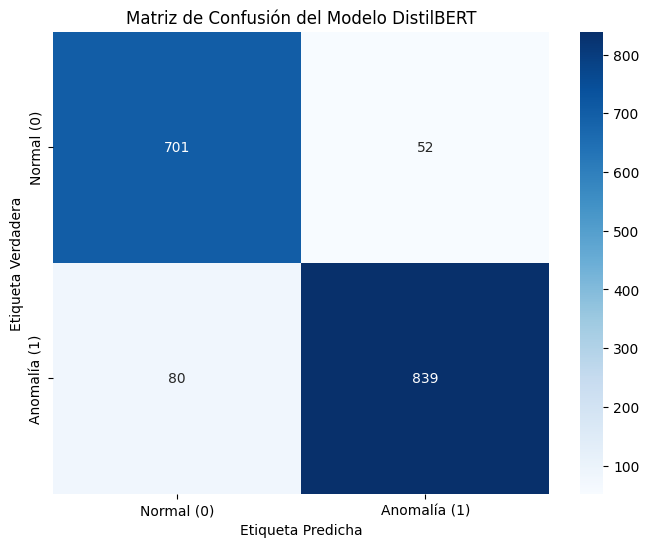

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# La matriz que obtuviste
cm_data = [[701, 52],
           [80, 839]]

# Etiquetas para los ejes (0=Normal, 1=Anomalía)
labels = ['Normal (0)', 'Anomalía (1)']

# Crear la figura y el eje
plt.figure(figsize=(8, 6))

# Dibujar el mapa de calor (heatmap) de la matriz
sns.heatmap(
    cm_data,
    annot=True,              # Mostrar los valores numéricos
    fmt="d",                 # Formato de números enteros
    cmap="Blues",            # Esquema de color (puedes cambiarlo)
    xticklabels=labels,      # Etiquetas del eje X (Predicción)
    yticklabels=labels       # Etiquetas del eje Y (Realidad)
)

# Añadir etiquetas y título
plt.title('Matriz de Confusión del Modelo DistilBERT')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')

# Mostrar el gráfico
plt.show()